In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import gpflow
import seaborn as sns

import sys
sys.path.insert(0,'..')
from inference_plots.tools.misc import sample_prior
dtype=np.float64
plt.rcParams['font.size']=22
from utils import make_deterministic
from inference_plots.tools.lmflow import PolynomialBasisKernel, SqExpBasisFunctionKernel, LMR
make_deterministic(42)

2022-08-08 17:13:38.297361: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-08 17:13:38.297381: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-08-08 17:13:39.368190: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-08 17:13:39.398257: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-08 17:13:39.399798: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_lo

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from sklearn.model_selection import train_test_split
N = 10  # Number of training observations

def func(x):
    return np.sin(x * 6) + 0.3 * np.cos(x * 3) #+ 0.5 * np.sin(x * 15)

X = np.random.rand(N, 1) * 2 - 1  # X values
Y = func(X) + 0.2 * np.random.randn(N, 1)  # Noisy Y values
X = X.astype(dtype)
Y = Y.astype(dtype)
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)
data = (X_train, y_train)
pX = np.linspace(-1.3, 1.3, 500)[:, None]

2022-08-08 17:13:41.512458: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-08 17:13:41.512525: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-08-08 17:13:41.512563: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-08-08 17:13:41.514355: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2022-08-08 17:13:41.514401: W tensorflow/stream_executor/platform/default/dso_loader

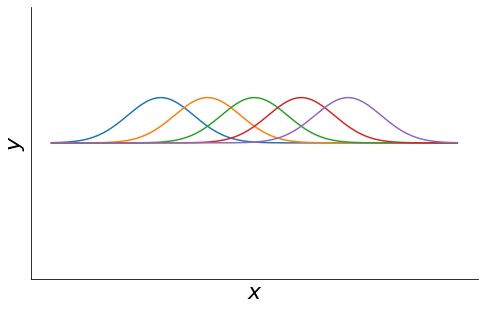

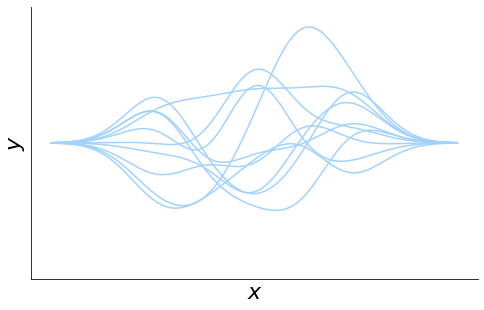

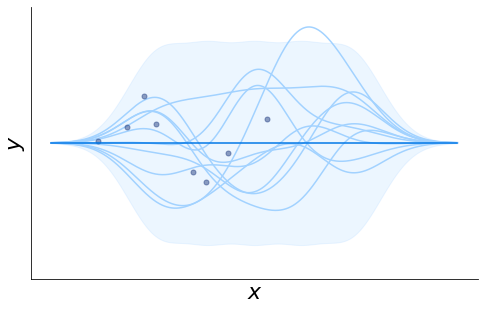

In [4]:
k = SqExpBasisFunctionKernel(5, (-0.6, 0.6), lengthscales=0.3)
m = LMR((X_train, y_train), k)
samples = sample_prior(k, pX)

plt.figure(figsize=(8, 5))
b_funcs = plt.plot(k.Phi(pX))
#ax1.set_xticks(np.linspace(-1.5, 1.5, 15))
plt.ylim(-3, 3)
plt.xticks([])
plt.yticks([])
sns.despine()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.savefig("../figures/basis_funcs/sqexp_basis_funcs.pdf")
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(pX, samples, alpha=1.0, c='#A2D2FF')
#obs = plt.plot(X_train, y_train, '.', markersize=10, color='#264185', alpha=0.5)
#prior_2sigma = m.kernel.K_diag(pX).numpy().flatten() ** 0.5 * 2.0
#plt.fill_between(pX.flatten(), -prior_2sigma, prior_2sigma, color='#A2D2FF', alpha=0.3)
plt.ylim(-3, 3)
sns.despine()
plt.xticks([])
plt.yticks([])
plt.xlabel("$x$")
plt.ylabel("$y$")
#plt.legend([samples, obs], ['function samples', 'observations'])
plt.savefig("../figures/basis_funcs/func_samples.pdf")
plt.show()


plt.figure(figsize=(8, 5))
plt.plot(pX, samples, alpha=1.0, c='#A2D2FF')
obs = plt.plot(X_train, y_train, '.', markersize=10, color='#264185', alpha=0.5)
plt.plot(pX, np.zeros_like(pX), c='#0077e6')
prior_2sigma = m.kernel.K_diag(pX).numpy().flatten() ** 0.5 * 2.0
plt.fill_between(pX.flatten(), -prior_2sigma, prior_2sigma, color='#A2D2FF', alpha=0.2)
plt.ylim(-3, 3)
sns.despine()
plt.xticks([])
plt.yticks([])
plt.xlabel("$x$")
plt.ylabel("$y$")
#plt.legend([samples, obs], ['function samples', 'observations'])
plt.savefig("../figures/basis_funcs/prior.pdf")


In [5]:
m = LMR((X_train, y_train), k)
opt = gpflow.optimizers.Scipy()
opt.minimize(m.training_loss, variables=m.trainable_variables)
print(m.log_marginal_likelihood().numpy())
gpflow.utilities.print_summary(m)

2022-08-08 17:13:42.567125: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


-4.5036708858828405
╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │     value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════╡
│ LMR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.842315  │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ LMR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.222086  │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ LMR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 0.0553212 │
╘═════════════════════════╧═══════════╧══════════════════╧══

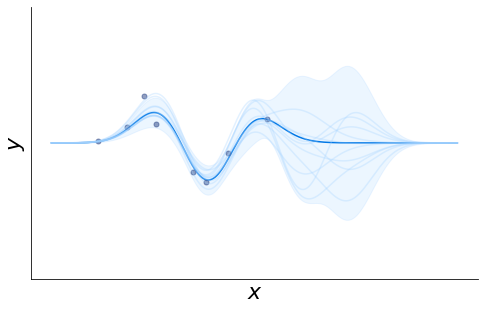

In [6]:
plot_samples = True
plt.figure(figsize=(8,5))

predict_stats = m.predict_f(pX)
pY, pYv = [d.numpy() for d in predict_stats]

plt.plot(pX, pY, lw=1.5, label="mean", color='#0077e6')
plt.fill_between(pX.flatten(), (pY - 2 * pYv ** 0.5).flatten(), (pY + 2 * pYv ** 0.5).flatten(), alpha=0.2,
                        label="2$\sigma$ func", color='#A2D2FF')
obs = plt.plot(X_train, y_train, '.', markersize=10, color='#264185', alpha=0.5)


if plot_samples:
    plot_samples_z = np.random.randn(len(pX), 10)
    mu, cov = m.predict_f(pX, full_cov=True)

    chol, jitter = None, 1e-8
    while chol is None:
        try:
            chol = np.linalg.cholesky(cov[0, :, :] + jitter * np.eye(cov.shape[1]))
        except np.linalg.LinAlgError:
            jitter *= 10
            # print(jitter)
    f_samples = mu + chol @ plot_samples_z
    # m.predict_f_samples(num_samples=10)
    plt.plot(pX.flatten(), f_samples, color='#A2D2FF', alpha=0.3)
plt.ylim(-3, 3)
plt.xticks([])
plt.yticks([])
sns.despine()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.savefig("../figures/basis_funcs/sqexp_basis_posterior.pdf")

In [7]:
def quad_f(x):
    return 3*x**2 + np.random.normal(0.0, 0.05, size=(x.shape))

x = np.random.uniform(-1, 1, 50)
y = quad_f(x)
m = LMR((x[:, None], y[:, None]), PolynomialBasisKernel(1))
m.kernel.lengthscales = 2.8
m.likelihood.variance.assign(1e-4)

<tf.Variable 'UnreadVariable' shape=() dtype=float64, numpy=-9.220341207421308>

In [8]:
opt = gpflow.optimizers.Scipy()
opt.minimize(m.training_loss, variables=m.trainable_variables)

      fun: 65.10039884127788
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([4.02059397e-05, 6.48116149e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 23
      nit: 22
     njev: 23
   status: 0
  success: True
        x: array([0.63814486, 0.02239304])

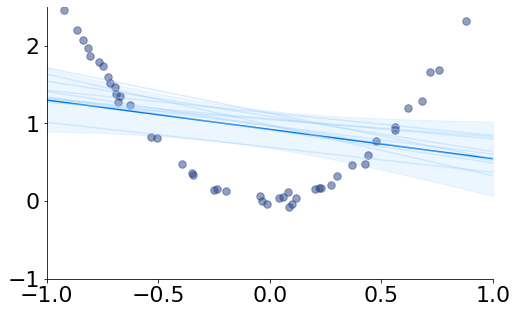

In [12]:
plt.figure(figsize=(8,5))
pX = np.linspace(-1, 1, 500)[:, None]
obs = plt.plot(x, y, '.', markersize=15, color='#264185', alpha=0.5)
predict_stats = m.predict_f(pX)
pY, pYv = [d.numpy() for d in predict_stats]
plt.plot(pX, pY, lw=1.5, label="mean", color='#0077e6')
plt.fill_between(pX.flatten(), (pY - 2 * pYv ** 0.5).flatten(), (pY + 2 * pYv ** 0.5).flatten(), alpha=0.2,
                        label="2$\sigma$ func", color='#A2D2FF')
plot_samples_z = np.random.randn(len(pX), 10)
mu, cov = m.predict_f(pX, full_cov=True)

chol, jitter = None, 1e-8
while chol is None:
    try:
        chol = np.linalg.cholesky(cov[0, :, :] + jitter * np.eye(cov.shape[1]))
    except np.linalg.LinAlgError:
        jitter *= 10
        # print(jitter)
f_samples = mu + chol @ plot_samples_z
# m.predict_f_samples(num_samples=10)
plt.plot(pX.flatten(), f_samples, color='#A2D2FF', alpha=0.4)

sns.despine()
plt.ylim((-0.5, 2.5))
plt.xlim((-1, 1))
plt.yticks([-1,0, 1, 2])
plt.xticks([-1, -0.5, 0, 0.5, 1])
plt.savefig("../figures/basis_funcs/linear_prior.pdf")

In [10]:
opt = gpflow.optimizers.Scipy()
opt.minimize(m.training_loss, variables=m.trainable_variables)

      fun: 65.10039884096946
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 3.50969711e-05, -1.30903566e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 3
      nit: 1
     njev: 3
   status: 0
  success: True
        x: array([0.63814097, 0.02238677])

In [11]:

#